# Final Project: Phase 3

Due to our less than stellar model performance, for the evaluation portion, we're going to be using a different regression problem as an example. In this one, we are looking at predicting the housing prices on datasets. Assume that our models are already tuned like we did last week. This week is more about how we do a final evaluation on tuned models.

---

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
from sklearn import datasets
import json
import warnings
warnings.filterwarnings('ignore')
random_state=42

## 3) Evaluation

Below is some scaffolding for generating a random sample of evaluation metrics

In [2]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

"""
Evaluates regression using MAE,MSE, and R^2
"""
def evaluate_regression(model,x_test_ev,y_test_ev):
    predictions = model.predict(x_test_ev)
    mae = mean_absolute_error(y_test_ev,predictions)
    mse = mean_squared_error(y_test_ev,predictions)
    r2 = r2_score(y_test_ev,predictions)
    return {"mae":mae,"mse":mse,"r2":r2}
    

In [3]:
"""
Trains and evaluates a single model on a random train/test split
"""
def evaluate_random(model,X_train,y_train,X_test,y_test):
    model.fit(X_train,y_train)
    
    evals = evaluate_regression(model,X_test,y_test)
    
    return evals

In [4]:
from sklearn.model_selection import train_test_split

"""
Input:
    X: Your features
    y: Your target
    models: A list of the models that you are evaluating
    n_trials (opt): The number of random trials
    
Output:
    A dataframe with three colums and len(models)*n_trials*(number of evaluation metrics) rows.
    Each row represents a single random evaluation.
    
    Model: The name of the model being evaluated
    Evaluation: The name of the evaluation (e.g. acc, precision, MSE)
    Score: The score of the evaluation
"""
def get_scores(X,y,models,n_trials=5):
    
    data = {
        "model": [],
        "evaluation": [],
        "score": [],
    }
    
    for n in range(n_trials):
        for model in models:
            X_train,X_test,y_train,y_test = train_test_split(X,y)
            
            scaler = MinMaxScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
            
            scores = evaluate_random(model,X_train,y_train,X_test,y_test)
            
            for key in scores:
                data["model"].append(str(model))
                data["evaluation"].append(key)
                data["score"].append(scores[key])
    
    return pd.DataFrame.from_dict(data)
        

## 3.1) Model Comparision
Let's say that we have our three different models and we've selected our final set of hyperparams.

In [5]:
from sklearn.datasets import load_boston
from sklearn.preprocessing import MinMaxScaler

In [6]:
X, y = load_boston(return_X_y=True)

In [7]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=random_state)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
from sklearn.linear_model import LinearRegression
lreg = LinearRegression().fit(X_train,y_train)
evaluate_regression(lreg,X_test,y_test)

{'mae': 3.0609395954370338, 'mse': 22.09869482709801, 'r2': 0.6844267283527128}

In [9]:
from sklearn.svm import SVR
svr = SVR(C=10,kernel="rbf").fit(X_train,y_train)
evaluate_regression(svr,X_test,y_test)

{'mae': 2.21054994279381, 'mse': 15.19826647392143, 'r2': 0.782966066002166}

In [10]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(max_iter=1000).fit(X_train,y_train)
evaluate_regression(mlp,X_test,y_test)

{'mae': 3.166807567602944, 'mse': 24.90216839918262, 'r2': 0.6443926297762392}

To be completely sure in our evaluation, we wish to try multiple random restarts and make sure our performance wasn't a fluke

In [11]:
scores = get_scores(X,y,[lreg,svr,mlp],n_trials=5)

In [12]:
scores.head()

,model,evaluation,score
0,LinearRegression(),mae,3.546190
1,LinearRegression(),mse,27.330470
2,LinearRegression(),r2,0.705277
3,SVR(C=10),mae,2.056957
4,SVR(C=10),mse,13.556251


Now, let's plot our results!

Text(0.5, 1.0, 'R^2 Comparision')

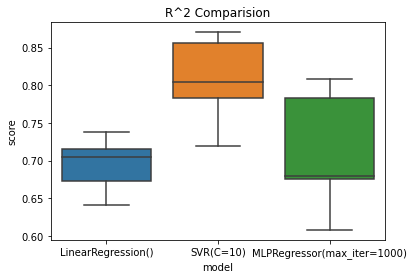

In [13]:
ax = sns.boxplot(x="model",y="score",data=scores[scores["evaluation"]=="r2"])
ax.set_title("R^2 Comparision")

Text(0.5, 1.0, 'MAE Comparision')

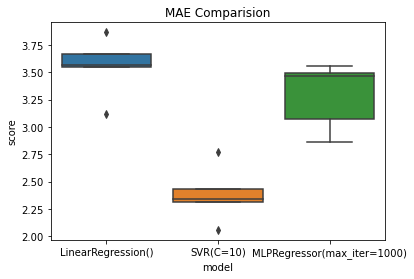

In [14]:
ax = sns.boxplot(x="model",y="score",data=scores[scores["evaluation"]=="mae"])
ax.set_title("MAE Comparision")

Text(0.5, 1.0, 'MSE Comparision')

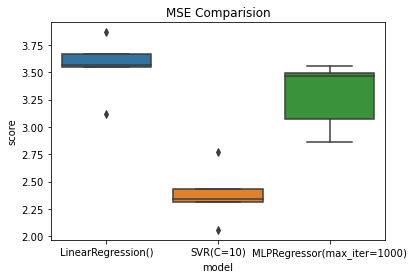

In [15]:
ax = sns.boxplot(x="model",y="score",data=scores[scores["evaluation"]=="mae"])
ax.set_title("MSE Comparision")

## 4.0) Technical Retrospective

Now that you have your final model, go back and look at how your decisions impacted the results. This can take many forms, here are some ideas:

* Which of your decisions were helpful? With your best model:
    * Compare the results of the model with an without your feature selection
    * Compare the results with and without feature engineering
    * Compare if your sampling method made a difference
    
    
* Why did your model do well?
    * If your model is interpretable, discuss feature importance (e.g. decision tree splits, coefficients of linear regression)

Let's take our look at the linear regression coeficcents as an example

In [16]:
lreg.coef_

array([ -6.79886418,   5.04694988,   0.63870852,   3.29024639,
        -8.26768036,  16.64863976,   1.47687907, -13.61765963,
         7.12482459,  -6.47862918,  -8.44147712,   4.21058817,
       -22.00609854])

Here's a list of the features in that order

* CRIM per capita crime rate by town
* ZN proportion of residential land zoned for lots over 25,000 sq.ft.
* INDUS proportion of non-retail business acres per town
* CHAS Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
* NOX nitric oxides concentration (parts per 10 million)
* RM average number of rooms per dwelling
* AGE proportion of owner-occupied units built prior to 1940
* DIS weighted distances to five Boston employment centres
* RAD index of accessibility to radial highways
* TAX full-value property-tax rate per \$10,000
* PTRATIO pupil-teacher ratio by town
* B $1000(Bk - 0.63)^2$ where Bk is the proportion of black people by town
* LSTAT % lower status of the population
* MEDV Median value of owner-occupied homes in $1000’s

What do these coefficients tell us?